# Case study hybrid forecast example

## Package requirements
- xarray
- xesmf
- matplotlib
- numpy
- scipy
- seaborn
- dask (optional, if don't have remove "with ProgressBar():" lines to remove progress indicators when computing data)
- cartopy
- pandas
  
## Input data required
- Equatorial wave divergence and vorticity at 850hPa for your event. Preferably 10 days prior to the event and 10 days after peak of event (Supplemental script wave_calc.ipynb shows this calculation from a full wave dataset)
- Default data format is netcdf that is loaded using xarray. Other formats compatible with xarray could be used (or edits required)
- Precipitation data for your event, same period (default is GPM). Heavy rainfall stats are precalculated here using calc_hiw_data.py
- Optional precipitation probabilistic forecast for comparisons

## Import relevant scripts

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import xesmf as xe
import glob
from dask.diagnostics import ProgressBar
from scipy import interpolate
from itertools import product
import hybrid_functions as H

from warnings import filterwarnings
filterwarnings('ignore')

## Define case study details

In [4]:
region='PM'
season='DJF'
event_start = np.datetime64('2021-12-18')
#event_start = np.datetime64('2022-12-08')

#region range [lon1, lon2, lat1, lat2] for plotting
full_range = [90,110,-5,15]

#wave_range (5 degree longitude region centred over region with whole number center)
wave_range = {'PM':[99.5,104.5],
              'EM':[112.5,117.5],
              'NI':[112.5,117.5],
              'WI':[97.5,102.5],
              'SP':[122.5,127.5],
              'CV':[105.5,110.5]}[region]

## Load precipitation and wave and plot during event

In [8]:
ws_path = '/gws/nopw/j04/ncas_climate_vol1/users/bc917929/'

date_sl = slice((np.datetime64(event_start)-np.timedelta64(1)).astype(str).item(),(np.datetime64(event_start)+np.timedelta64(1)).astype(str).item())

pr_event = xr.open_dataarray('./inputs/gpm_pr_anom_event.nc')
Kelv = xr.open_dataset('./inputs/Kelv_event.nc')
R1 = xr.open_dataset('./inputs/R1_event.nc')
WMRG= xr.open_dataset('./inputs/WMRG_event.nc')

In [9]:
Kelv

<xarray.Dataset> Size: 36MB
Dimensions:              (time: 84, lat: 49, lon: 360)
Coordinates:
  * time                 (time) datetime64[ns] 672B 2021-12-08 ... 2021-12-28...
  * lat                  (lat) float64 392B -24.0 -23.0 -22.0 ... 22.0 23.0 24.0
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    dayofyear            (time) int64 672B ...
Data variables:
    eastward_wind        (time, lat, lon) float64 12MB ...
    geopotential_height  (time, lat, lon) float64 12MB ...
    divergence           (time, lat, lon) float64 12MB ...

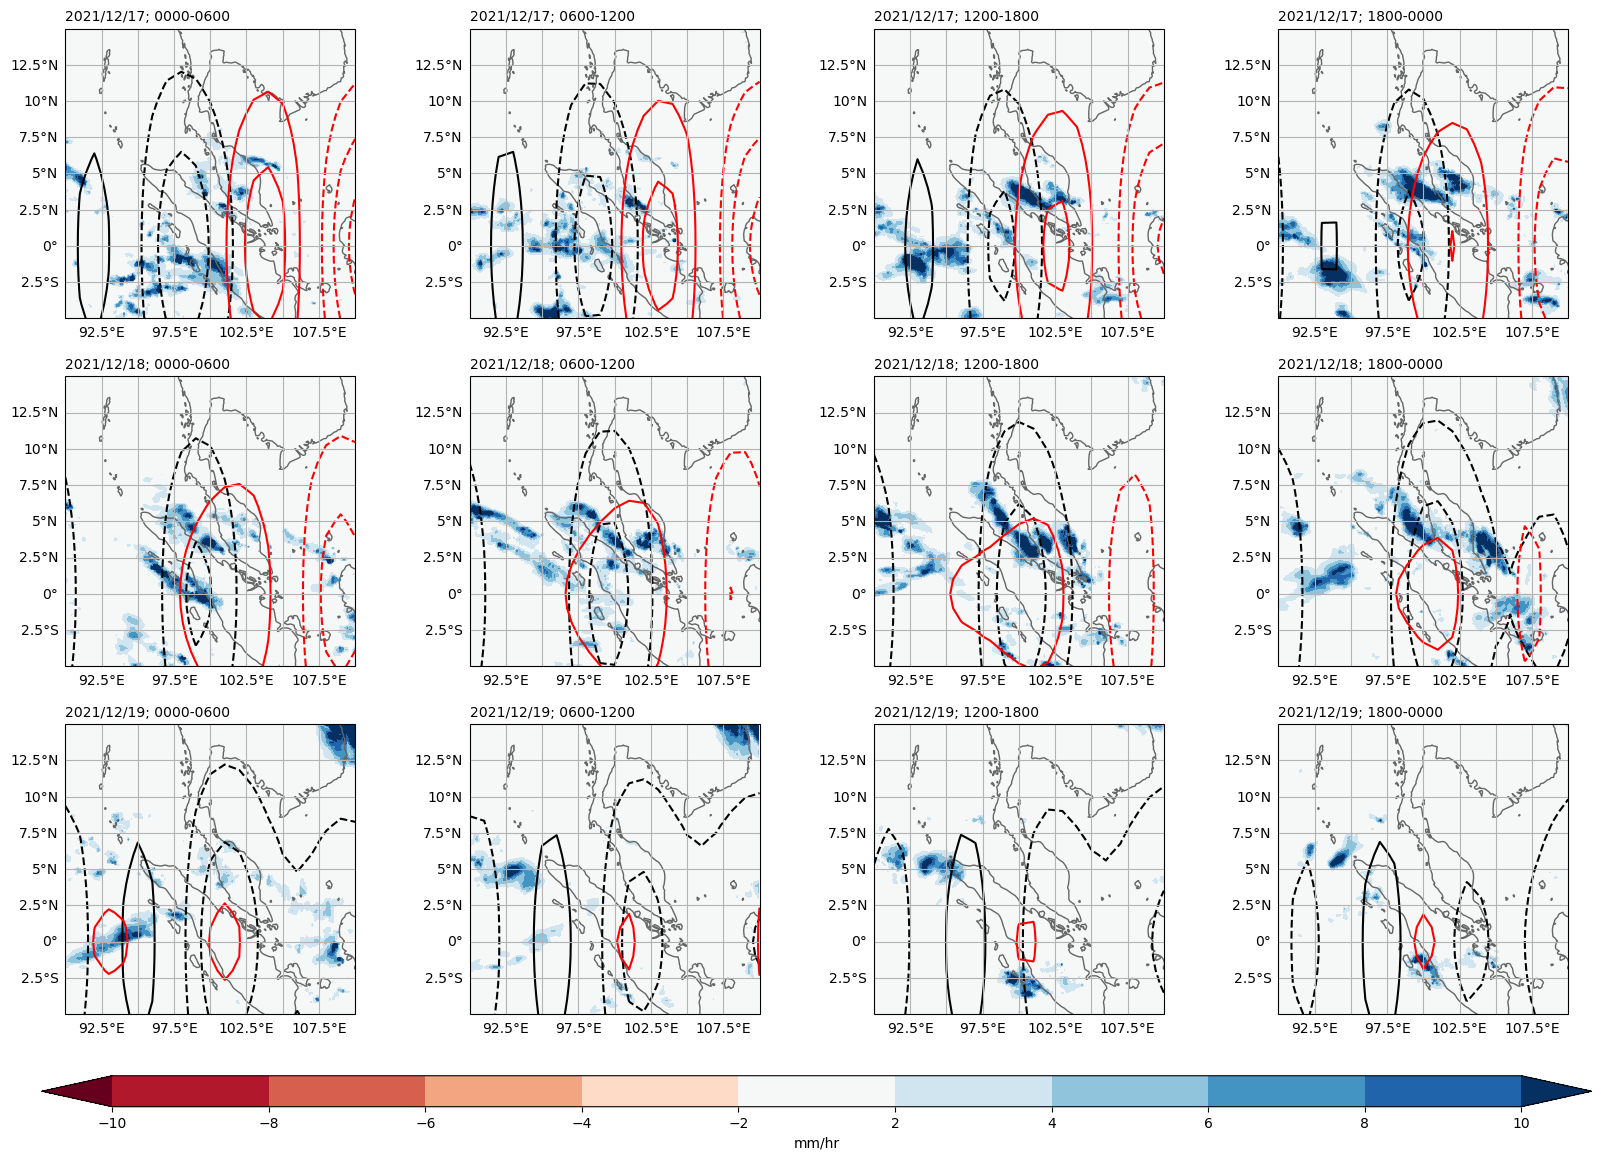

In [11]:
toplot = pr_event.sel(lon=slice(*full_range[:2]),lat=slice(*full_range[2:]))
divtoplot = Kelv.divergence.sel(lon=slice(*full_range[:2]),lat=slice(*full_range[2:])).sel(time=date_sl)
vortoplot = WMRG.vorticity.sel(lon=slice(*full_range[:2]),lat=slice(*full_range[2:])).sel(time=date_sl)

start = date_sl.start.replace('-','')
end = date_sl.stop.replace('-','')
levels = list(filter(lambda i: i!=0,np.linspace(-10,10,11)))
              
fig,axs = plt.subplots(nrows=3,ncols=4,subplot_kw = {'projection':ccrs.PlateCarree(180)},figsize=[20,16])
for i,ax in enumerate(np.ravel(axs)):
    cont = toplot.isel(time=i).plot.contourf(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),levels=levels,extend='both',cmap=plt.cm.RdBu,add_colorbar=False)
    divtoplot.isel(time=i).plot.contour(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),levels=np.array(levels)*5e-7,colors='black')
    vortoplot.isel(time=i).plot.contour(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),levels=np.array(levels)*2.5e-6,colors='red')
    date = pd.to_datetime(toplot.isel(time=i).time.values).strftime('%Y/%m/%d')
    #print(date)
    ax.set_title('')
    ax.set_title(f'{date}; {i*6%24:02d}00-{(i*6+6)%24:02d}00',fontsize=10,loc='left')
    ax.coastlines(color='.4')
    gl=ax.gridlines(draw_labels=True,color='.7')
    gl.top_labels=False
    gl.right_labels=False
plt.colorbar(cont,ax=axs,orientation='horizontal',pad=.05,aspect=50,label='mm/hr')

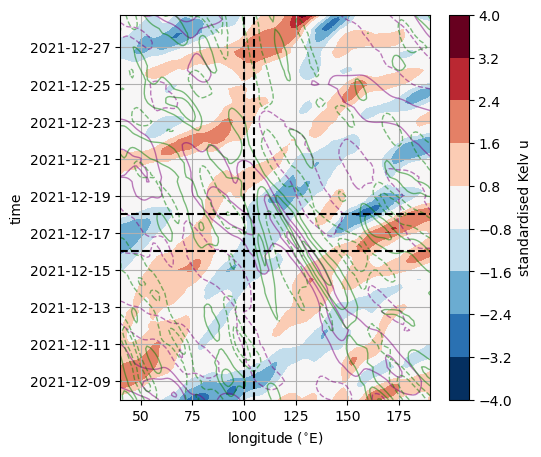

In [13]:
Kelv_hov = Kelv.eastward_wind.sel(lat=0,lon=slice(40,190))
R1_hov = R1.eastward_wind.sel(lat=0,lon=slice(40,190))
WMRG_hov = WMRG.northward_wind.sel(lat=0,lon=slice(40,190))
Kelv_hov, R1_hov, WMRG_hov = [nc/nc.std('time') for nc in [Kelv_hov, R1_hov, WMRG_hov]]

levels = list(filter(lambda n: n!=0,np.linspace(-4,4,11)))
levels2 = list(filter(lambda n: n!=0,np.arange(-4,5,1)))

fig,ax = plt.subplots(figsize=[5,5])
Kelv_hov.plot.contourf(ax=ax,levels=levels)
R1_hov.plot.contour(ax=ax,levels=levels2,colors='purple',linewidths=1,alpha=.5)
WMRG_hov.plot.contour(ax=ax,levels=levels2,colors='green',linewidths=1,alpha=.5)
ax.grid()
ax.axhline(np.datetime64('2021-12-16'),linestyle='dashed',color='k')
ax.axhline(np.datetime64('2021-12-18'),linestyle='dashed',color='k')
[ax.axvline(l,linestyle='dashed',color='k') for l in [100,105]]
fig.axes[-1].set_ylabel('standardised Kelv u')
ax.set_xlabel(r'longitude ($^{\circ}$E)')
ax.set_title('')
plt.show()

## Load pre-calculated (calc_hiw_data.py) HIW data

In [14]:
#date ranges, 21 days starting 17 days before event and 3 days following event
startdate = (event_start - np.timedelta64(17)).astype(str).item()
enddate = (event_start + np.timedelta64(3)).astype(str).item()


In [15]:
#optional

#ref gpm and threshold calculation
#see calc_hiw_data.py or calculate own thresholds etc.
#import calc_hiw_data

#OR
#load pre-calculated thresholds

thresholds = xr.open_dataset(f'./inputs/GPM_hiw_pc10_{region}_{season}.nc')
area_thres,pr_count = xr.DataArray([thresholds.attrs['area_thres']],{'season':[season]}), thresholds.pr_count
thresholds_son = xr.open_dataset(f'./inputs/GPM_hiw_pc10_{region}_SON.nc')
area_thres_son,pr_count_son = xr.DataArray([thresholds_son.attrs['area_thres']],{'season':['SON']}), thresholds_son.pr_count

In [16]:
#% of area exceeding 95th percentile of regions rainfall
pr_count = xr.concat([pr_count_son,pr_count],'time')
pr_count = pr_count.reindex(time=np.sort(pr_count.time))
pr_bool = pr_count.groupby('time.season') > xr.concat([area_thres_son,area_thres],'season')
pr_case = pr_bool.sel(time=slice(startdate,enddate))
event_date = pr_case.time[pr_case.values]

## Plot - percentage of area of defined region that experiences heavy rainfall

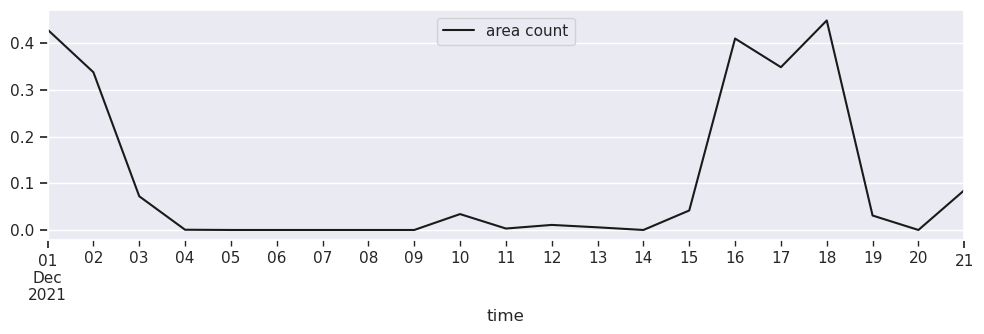

In [17]:

sns.set()
plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True
fig,ax=plt.subplots(figsize=[10,3.5])
pr_count.sel(time=slice(startdate,enddate)).to_dataframe('area count')[['area count']].plot(ax=ax,color='k')
plt.tight_layout()
#plt.savefig(f'/home/users/bc917929/forsea_fo_co/figs/casestudy/{region}_gpmavg_{startdate}-{enddate}.png',bbox_inches='tight',pad_inches=.1,dpi=300)


## Calculate wave-based hybrid fc for case

In [18]:
def build_hybrid(waves=['Kelv','R1'],region='PM',season='DJF',pc=10):
    '''
    Function to retrieve probabilies from pre-calculated conditional probability and forecast wave data (in
    this case pre-calculated GloSea6 wave phase data is used)
    
    Inputs
    ---
    waves (list)       - list of waves for hybrid forecast to be built. Needs to be one of:
                            ['Kelv'],['R1'],['Kelv'],['Kelv','R1'],['Kelv','WMRG'],['R1','WMRG']
    region (string)    - string of region required (for this script only 'PM' available)
    season (string)    - season to build hybrid forecast (for this script only 'DJF' available)
    pc (int)           - frequency (%) of heavy rainfall event (for this script only 10 available)

    Outputs
    ---
    condprob (xarray.DataSet)   - hybrid probabilistic forecast in format:
                                initialisation time, lead time, ensemble member no.
    '''
    
    #load pre-calculated conditional probabilities and make correct format
    #see hybrid_functions.py function prob_construct_waves() to see the method
    pi = xr.open_dataarray(f'./inputs/pi_{region}_{season}_{"_".join(waves)}_pc{pc:02d}.nc')
    if len(waves)>1:
        pi_df = pi.to_dataframe(name='pi').unstack()
        pi_df.columns = pi_df.columns.droplevel()
        pi_df = pi_df.transpose()
        max_amp=1
    else:
        pi_df = pi.to_dataframe(name='pi').unstack()
        pi_df.index = pi_df.index.droplevel()
        max_amp=2

    #load wave forecasts and calculate phase information
    wave_ncs = {w:xr.open_dataset(f'./inputs/GS6/phase_{w}_{wave_range[0]}-{wave_range[1]}.nc')
         for w in waves}
    wave_phases = {w:H.create_phase(wave_ncs[w].wave_phase,wave_ncs[w].wave_amplitude,max_amp=max_amp)
        for w in wave_ncs}

    #retrieve the correct probabilities
    if len(waves)>1:
        retrieve_func = np.vectorize(lambda i,j: H.retrieve_func_dual(pi_df,i,j))
        condprob = retrieve_func(wave_phases[waves[0]],wave_phases[waves[1]])
        condprob = wave_phases[waves[0]].copy(data=condprob)
        condprob.name = f'{"_".join(waves)}_condprob'
    else:
        retrieve_func = np.vectorize(lambda i: H.retrieve_func_single(pi_df,i))
        condprob = retrieve_func(wave_phases[waves[0]])
        condprob = wave_phases[waves[0]].copy(data=condprob)
        condprob.name = f'{waves[0]}_condprob'
        
    return condprob

In [19]:
condprobs=[]
for w in [['Kelv'],['R1'],['WMRG'],['Kelv','R1'],['Kelv','WMRG'],['R1','WMRG']]:
    print(f'Calculating hybrid forecast for {"+".join(w)}')
    condprobs.append(build_hybrid(w))
condprobs = xr.merge(condprobs,compat='override').squeeze()

Calculating hybrid forecast for Kelv
Calculating hybrid forecast for R1
Calculating hybrid forecast for WMRG
Calculating hybrid forecast for Kelv+R1
Calculating hybrid forecast for Kelv+WMRG
Calculating hybrid forecast for R1+WMRG


In [20]:
condprobs


<xarray.Dataset> Size: 9MB
Dimensions:             (time: 691, number: 4, lead: 70)
Coordinates:
  * time                (time) datetime64[ns] 6kB 2021-02-03 ... 2022-12-31
    pressure            int64 8B 850
  * number              (number) int64 32B 0 1 2 3
    latitude            float32 4B 0.0
  * lead                (lead) timedelta64[ns] 560B -9 days -8 days ... 60 days
    mode                int64 8B 0
Data variables:
    Kelv_condprob       (time, lead, number) float64 2MB 0.02174 ... 0.0941
    R1_condprob         (time, lead, number) float64 2MB 0.2766 ... 0.07692
    WMRG_condprob       (time, lead, number) float64 2MB 0.1558 ... 0.1224
    Kelv_R1_condprob    (time, lead, number) float64 2MB 0.1875 ... 0.1111
    Kelv_WMRG_condprob  (time, lead, number) float64 2MB 0.1765 ... 0.07692
    R1_WMRG_condprob    (time, lead, number) float64 2MB 0.1538 ... 0.1622

## Plot - Wave hybrid forecast figure

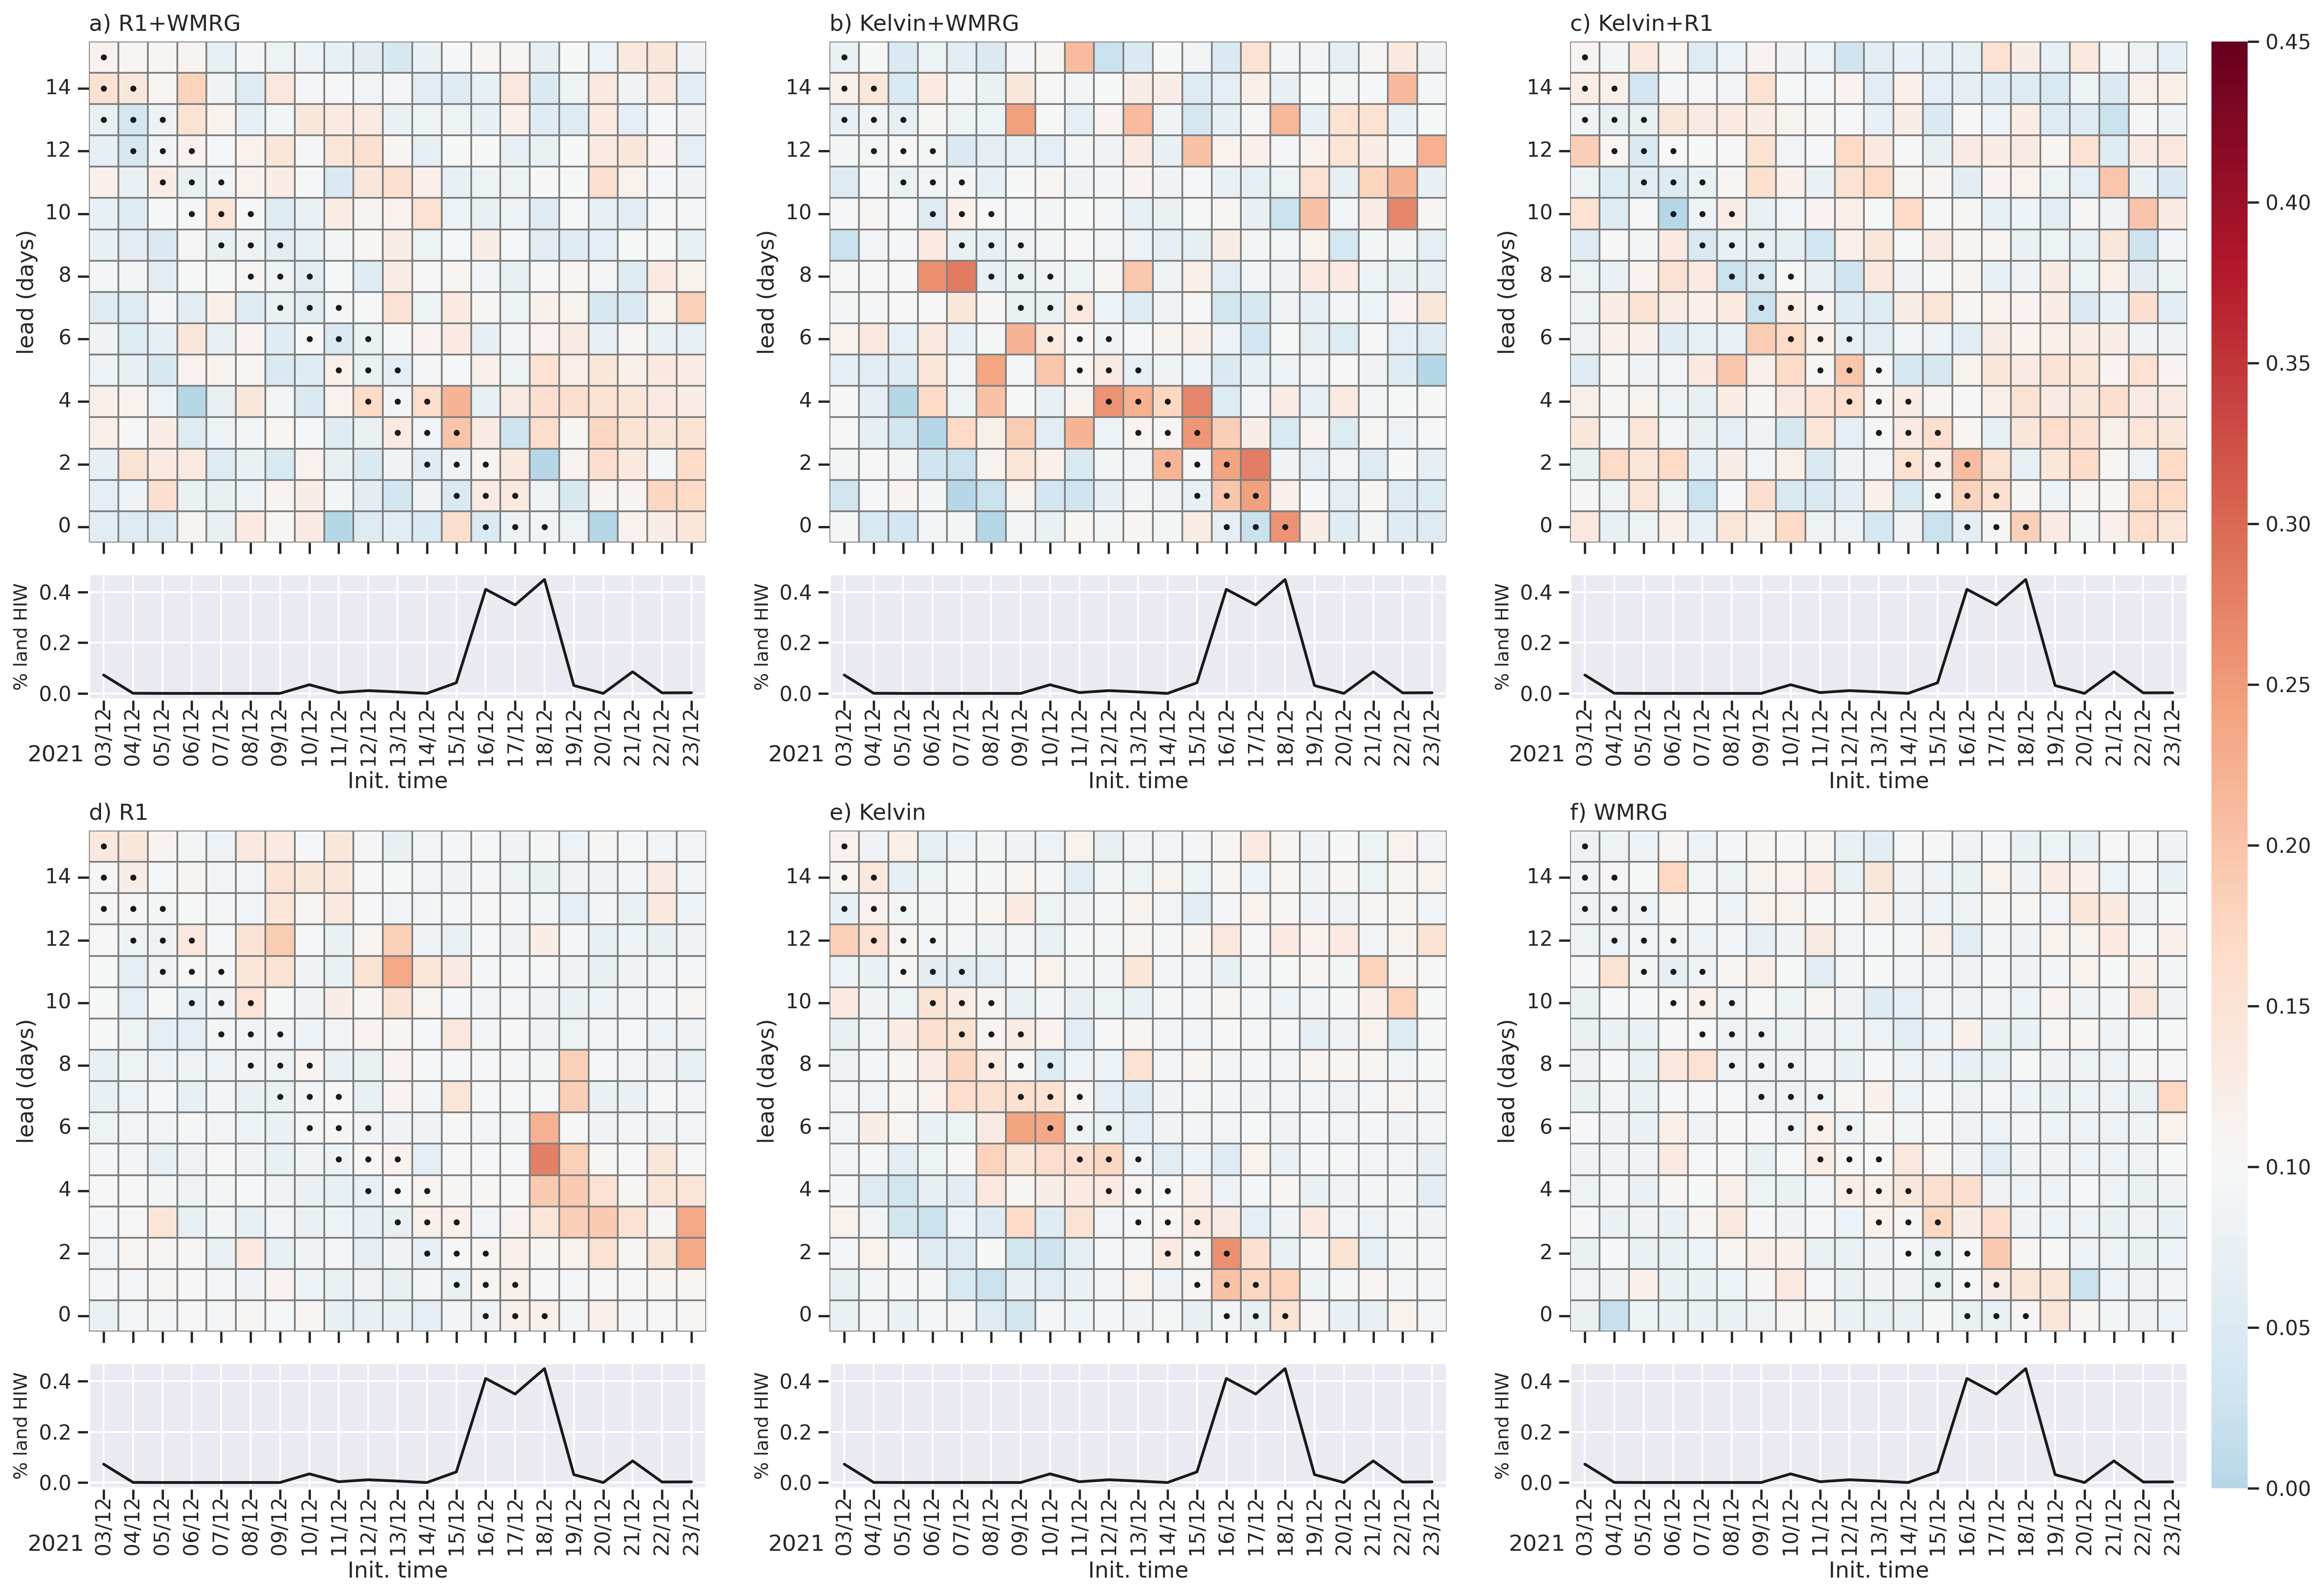

In [21]:
#wave probability figure
#event_start = np.datetime64('2021-12-18')

startdate = (event_start - np.timedelta64(15)).astype(str).item()
enddate = (event_start + np.timedelta64(5)).astype(str).item()

newt = pd.date_range(startdate,enddate)
condprobs_sub = condprobs.sel(time=slice(startdate,enddate)).interp(time=newt)

plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True

#sns.set(style='darkgrid')

fig=plt.figure(figsize=[18,12],dpi=300)
gs0 = gridspec.GridSpec(2, 1, figure=fig,**{'hspace':0.2,'top':0.95,'left':0.05,'bottom':0.05,'right':0.92})
gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],height_ratios=(4,1),hspace=0.1)
axs0 = [fig.add_subplot(gs00[i, j]) for i,j in product(range(2),range(3))]
gs01 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1],height_ratios=(4,1),hspace=0.1)
axs1 = [fig.add_subplot(gs01[i, j]) for i,j in product(range(2),range(3))]
ax2 = fig.add_axes([0.93, 0.05, 0.015, 0.9])


axs=axs0[:3]+axs1[:3]
kwargs = {'cmap':plt.cm.RdBu_r,'xticklabels':pd.date_range(startdate,enddate).strftime('%d/%m'),'vmin':-0.25,'vmax':0.45,'cbar':False,
         'linewidths':.5,'linecolor':'.5'}
hm = sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').R1_WMRG_condprob.to_dataframe()['R1_WMRG_condprob'].unstack().transpose(),
    ax=axs[0],**kwargs)
sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').Kelv_WMRG_condprob.to_dataframe()['Kelv_WMRG_condprob'].unstack().transpose(),
    ax=axs[1],**kwargs)
sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').Kelv_R1_condprob.to_dataframe()['Kelv_R1_condprob'].unstack().transpose(),
    ax=axs[2],**kwargs)
sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').R1_condprob.to_dataframe()['R1_condprob'].unstack().transpose(),
    ax=axs[3],**kwargs)
sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').Kelv_condprob.to_dataframe()['Kelv_condprob'].unstack().transpose(),
    ax=axs[4],**kwargs)
kwargs.update({'cbar':True})
sns.heatmap(condprobs_sub.sel(time=slice(startdate,enddate),lead=slice('0 days','15 days')).mean('number').WMRG_condprob.to_dataframe()['WMRG_condprob'].unstack().transpose(),
    ax=axs[5],cbar_ax=ax2,**kwargs)
ndays = (event_date.values-np.datetime64(startdate)).astype('timedelta64[D]').astype(float)
for ax,w,l in zip(axs,['R1+WMRG','Kelvin+WMRG','Kelvin+R1','R1','Kelvin','WMRG'],'abcdef'):
    xticks = ax.get_xticks()
    xticklabels = [i.get_text() for i in ax.get_xticklabels().copy()]
    ax.set(yticks=np.arange(0,16,2)+.5,yticklabels = np.arange(0,16,2),ylabel='lead (days)',xticklabels='',xlabel='')
    ax.invert_yaxis()
    [ax.scatter(ndays+.5-i,[.5+i]*len(ndays),color='k',s=5) for i in range(0,16,1)]
    ax.set_title(f'{l}) {w}',loc='left')

fig.axes[-1].set_ylim([0,0.45])

for ax in axs0[3:]+axs1[3:]:
    ax.tick_params('x',pad=-2)

    sns.lineplot(x=np.arange(0.5,21,1),y=pr_count.sel(time=slice(startdate,enddate)).to_dataframe('area count')[['area count']].values.squeeze(),ax=ax,color='k')#.plot(ax=axs0[3],color='k')
    ax.set_xlim(axs0[0].get_xlim())
    ax.set(xticks=xticks)
    ax.set_ylabel('% land HIW',fontsize=10)
    ax.set_xlabel('Init. time',labelpad=3)
    ax.set_xticklabels(xticklabels,rotation=90)
    #ax.tick_params('x',pad=-3,width=5,length=3)
    ax.text(-0.1,-0.5,str(event_start)[:4], transform=ax.transAxes,fontsize=12)



Text(-0.1, -0.5, '2021')

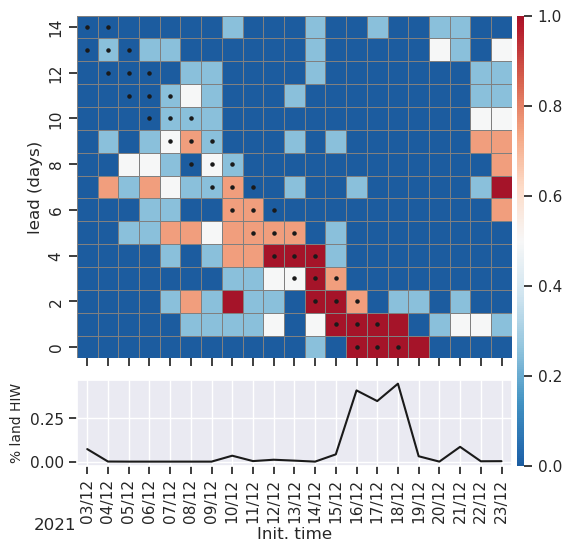

In [23]:
#second event
#event_start = np.datetime64('2022-12-08')

startdate = (event_start - np.timedelta64(15)).astype(str).item()
enddate = (event_start + np.timedelta64(5)).astype(str).item()
GS6_prob = xr.open_dataarray('./inputs/GS6/GS6_pr_event.nc')
kwargs = {'cmap':plt.cm.RdBu_r,'xticklabels':pd.date_range(startdate,enddate).strftime('%d/%m'),'vmin':-0.1,'vmax':1.1,'cbar':True,
         'linewidths':.5,'linecolor':'.5'}

plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True

fig=plt.figure(figsize=[5,5],dpi=100)
gs = gridspec.GridSpec(2, 1, figure=fig,height_ratios=(4,1),**{'hspace':0.1,'top':0.95,'left':0.05,'bottom':0.05,'right':0.92})
ax = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax_leg = fig.add_axes([0.93, 0.05, 0.015, 0.9])

hm = sns.heatmap(GS6_prob.sel(time=slice(startdate,enddate),lead=slice(0,15)).transpose(),ax=ax,cbar_ax=ax_leg,
    **kwargs)
ax.invert_yaxis()
xticklabels = [i.get_text() for i in ax.get_xticklabels().copy()]
xticks = ax.get_xticks()
ax.set(yticks=np.arange(0,16,2)+.5,yticklabels = np.arange(0,16,2),ylabel='lead (days)',xticklabels='',xlabel='')

[ax.scatter(ndays+.5-i,[.5+i]*len(ndays),color='k',s=5) for i in range(0,16,1)]
fig.axes[-1].set_ylim([0,1])

ax.tick_params('x',pad=-2)

sns.lineplot(x=np.arange(0.5,21,1),y=pr_count.sel(time=slice(startdate,enddate)).to_dataframe('area count')[['area count']].values.squeeze(),ax=ax2,color='k')
ax2.set_xlim(axs0[0].get_xlim())
ax2.set(xticks=xticks)
ax2.set_ylabel('% land HIW',fontsize=10)
ax2.set_xlabel('Init. time',labelpad=3)
ax2.set_xticklabels(xticklabels,rotation=90)
#ax.tick_params('x',pad=-3,width=5,length=3)
ax2.text(-0.1,-0.5,str(event_start)[:4], transform=ax.transAxes,fontsize=12)



Text(0, 0.5, 'GPM % area heavy rainfall')

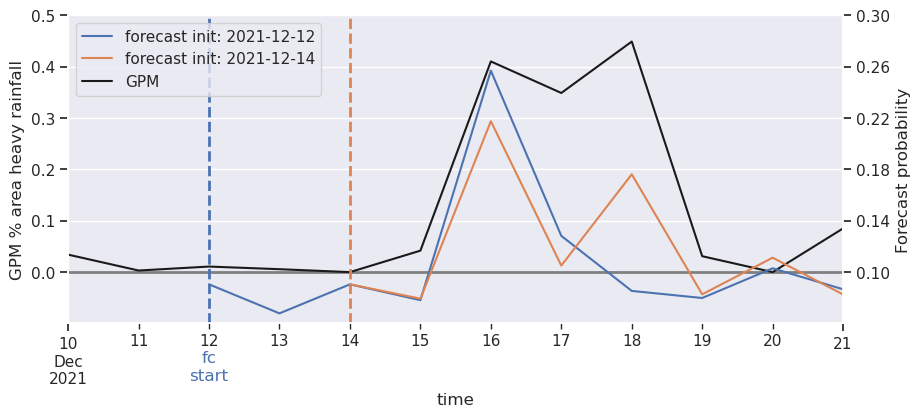

In [30]:
fc_starts = [np.datetime64('2021-12-12'),np.datetime64('2021-12-14')]
plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True

fig,ax = plt.subplots(figsize=[10,4])
ax2 = ax.twinx()

pr_count.sel(time=slice(startdate,enddate)).to_dataframe('area count')[['area count']].plot(ax=ax,color='k',zorder=2,legend=False)

for fc_start,c in zip(fc_starts,['C0','C1','C2']):
    fc_df = condprobs.sel(time=fc_start,lead=slice('0 days','25 days')).mean('number').Kelv_WMRG_condprob.assign_coords({'lead':pd.date_range(fc_start,fc_start+np.timedelta64(25))}).to_dataframe()['Kelv_WMRG_condprob']
    fc_df.plot(ax=ax2,color=c,label=f'forecast init: {str(fc_start)}')
    ax2.axvline(fc_start,linewidth=2,color=c,zorder=1,linestyle='dashed')
ax2.plot([], [], '-k', label = 'GPM')

plt.legend(loc='upper left')
#ax.set_ylim([-0.02,0.5])
ax.set_ylim([-0.1,0.5])
ax.set_yticks(np.arange(0,0.51,0.1))
ax2.set_ylim([0.06,0.3])
ax2.set_yticks(np.arange(0.1,0.31,0.04))
ax.set_xlim(['2021-12-10','2021-12-21'])
ax.axhline(0,color='.5',linewidth=2,zorder=1)
ax.text(x='2021-12-12',y=-0.185,s='fc\nstart',ha='center',va='center',color='C0')
ax2.grid(False)
ax2.set_ylabel('Forecast probability')
ax.set_ylabel('GPM % area heavy rainfall')





## Plot - regime-based probabilities

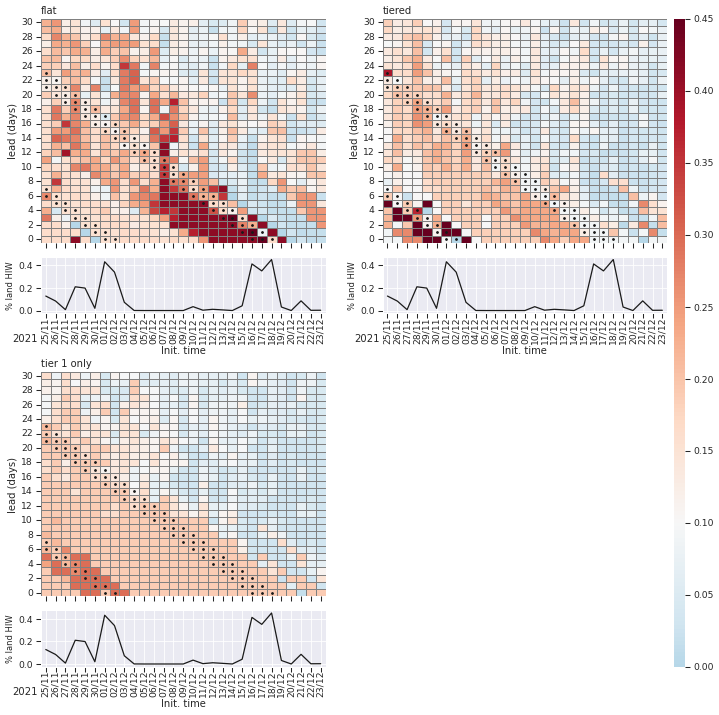

In [33]:
reg_prob = xr.open_dataset(f'/home/users/bc917929/forsea_fo_co/data/regime_probs/{region}_condprobs_pc90_{season}_native.nc')

startdate = (event_start - np.timedelta64(23)).astype(str).item()

plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True
#dpi 70 is just for display purposes. If saving the figure a higher dpi is probably preferred
fig=plt.figure(figsize=[12,12],dpi=60)
gs0 = gridspec.GridSpec(2, 1, figure=fig,**{'hspace':0.2,'top':0.95,'left':0.05,'bottom':0.05,'right':0.92})
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0],height_ratios=(4,1),hspace=0.1)
axs0 = [fig.add_subplot(gs00[i, j]) for i,j in product(range(2),range(2))]
gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1],height_ratios=(4,1),hspace=0.1)
axs1 = [fig.add_subplot(gs01[i, j]) for i,j in product(range(2),range(2))]
ax2 = fig.add_axes([0.93, 0.05, 0.015, 0.9])

axs = axs0[:2] + axs1[:2]
axs[3].axis('off')
kwargs = {'cmap':plt.cm.RdBu_r,'xticklabels':pd.date_range(startdate,enddate).strftime('%d/%m'),'vmin':-0.25,'vmax':0.45,'cbar':False,
         'linewidths':1,'linecolor':'.5'}
reg_prob = reg_prob.interp(time=pd.date_range(startdate,enddate))
sns.heatmap(reg_prob.sel(time=slice(startdate,enddate),lead=slice('0 days','30 days')).mean('number').flat_cond.to_dataframe()['flat_cond'].unstack().transpose(),
    ax=axs[0],**kwargs)
sns.heatmap(reg_prob.sel(time=slice(startdate,enddate),lead=slice('0 days','30 days')).mean('number').tier_cond.to_dataframe()['tier_cond'].unstack().transpose(),
    ax=axs[1],**kwargs)
kwargs.update({'cbar':True})
sns.heatmap(reg_prob.sel(time=slice(startdate,enddate),lead=slice('0 days','30 days')).mean('number').tier1_cond.to_dataframe()['tier1_cond'].unstack().transpose(),
    ax=axs[2],cbar_ax=ax2,**kwargs)

ndays = (event_date.values-np.datetime64(startdate)).astype('timedelta64[D]').astype(float)
for ax,w in zip(axs,['flat','tiered','tier 1 only']):
    xticks = ax.get_xticks()
    xticklabels = [i.get_text() for i in ax.get_xticklabels().copy()]
    ax.set(yticks=np.arange(0,31,2)+.5,yticklabels = np.arange(0,31,2),ylabel='lead (days)',xticklabels='',xlabel='')
    ax.invert_yaxis()
    [ax.scatter(ndays+.5-i,[.5+i]*len(ndays),color='k',s=5) for i in range(0,31,1)]
    ax.set_title(w,loc='left')
#fig.colorbar(hm)
fig.axes[-1].set_ylim([0,0.45])

for ax in axs0[2:]+axs1[2:3]:
    sns.set()
    ax.tick_params('x',pad=-2)

    sns.lineplot(x=np.arange(0.5,29,1),y=pr_count.sel(time=slice(startdate,enddate)).to_dataframe('area count')[['area count']].values.squeeze(),ax=ax,color='k')#.plot(ax=axs0[3],color='k')
    ax.set_xlim(axs0[0].get_xlim())
    ax.set(xticks=xticks)
    ax.set_xlabel('Init. time',labelpad=3)
    ax.set_ylabel('% land HIW',fontsize=10)
    ax.set_xticklabels(xticklabels,rotation=90)
    #ax.tick_params('x',pad=-3,width=5,length=3)
    ax.text(-0.1,-0.5,str(event_start)[:4], transform=ax.transAxes,fontsize=12)
axs1[-1].axis('off')
plt.show()